# Assignment - 7 


Group Number 10

#### Importing necessary libraries required for computation

In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import newton
import seaborn as sns
sns.set_context('notebook')
RANDOM_SEED = 20090425

#### Reading the CSV File 

* Following Dataset is a collection of rainfall in different districts of india  

In [80]:
rain_data = pd.read_csv("district wise rainfall normal.csv") 
rain_data.head()

STATE_UT_NAME       DISTRICT    JAN   FEB    MAR    APR  \
0  ANDAMAN And NICOBAR ISLANDS        NICOBAR  107.3  57.9   65.2  117.0   
1  ANDAMAN And NICOBAR ISLANDS  SOUTH ANDAMAN   43.7  26.0   18.6   90.5   
2  ANDAMAN And NICOBAR ISLANDS  N & M ANDAMAN   32.7  15.9    8.6   53.4   
3            ARUNACHAL PRADESH          LOHIT   42.2  80.8  176.4  358.5   
4            ARUNACHAL PRADESH     EAST SIANG   33.3  79.5  105.9  216.5   

     MAY    JUN    JUL    AUG    SEP    OCT    NOV    DEC  ANNUAL  Jan-Feb  \
0  358.5  295.5  285.0  271.9  354.8  326.0  315.2  250.9  2805.2    165.2   
1  374.4  457.2  421.3  423.1  455.6  301.2  275.8  128.3  3015.7     69.7   
2  343.6  503.3  465.4  460.9  454.8  276.1  198.6  100.0  2913.3     48.6   
3  306.4  447.0  660.1  427.8  313.6  167.1   34.1   29.8  3043.8    123.0   
4  323.0  738.3  990.9  711.2  568.0  206.9   29.5   31.7  4034.7    112.8   

   Mar-May  Jun-Sep  Oct-Dec  
0    540.7   1207.2    892.1  
1    483.5   1757.2    705.3  
2    405.6   1884.4    574.7  
3    841.3   1848.5    231.0  
4    645.4   3008.4    268.1

* Plotting Histogram for each Month

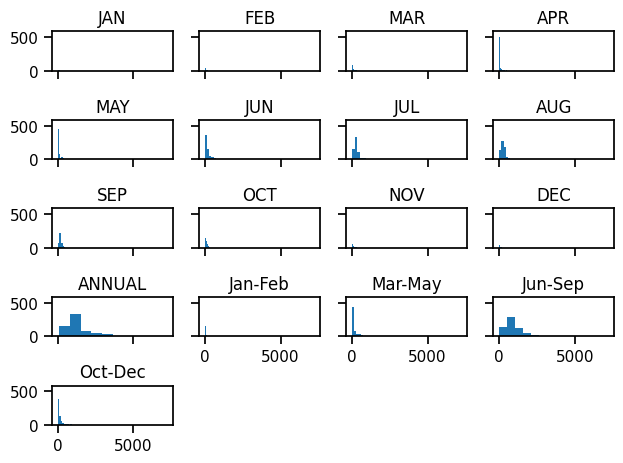

In [104]:
HISTOGRAM = df_data.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

* Plotting Histogram for the onth of June 

In [81]:
rain_data_jun = rain_data['JUN'] 
rain_data_jun.hist()

<AxesSubplot: >

* Storing Rainfall data for June and July

In [105]:
rain_data_jun = pd.read_csv("district wise rainfall normal.csv", na_values='NA', usecols=['JUN'])
rain_data_jul = pd.read_csv("district wise rainfall normal.csv", na_values='NA', usecols=['JUL'])

In [84]:
from scipy.special import psi, polygamma
# Note that log_mean and mean_log are parameters of the dlgamma function
dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

### Following is used to calculate MLE

$$\frac{\partial log(l)(\alpha,\beta)}{\partial \alpha} = \log(\alpha) + \overline{\log(x)} - \log(\bar{x}) - \frac{\partial log(\Gamma(\alpha))}{\partial\alpha} = 0$$

psi` and `polygamma` are complex functions of the Gamma function that result when you take first and second derivatives of that function. Specifically, 

[scipy.special.psi](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.psi.html) = $\frac{\partial log(\Gamma(\alpha))}{\partial\alpha}$ and 

[scipy.special.polygamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.polygamma.html) = $\frac{\partial^2 log(\Gamma(\alpha))}{\partial\alpha^2}$

In [106]:

log_mean = rain_data_jul.mean().apply(np.log)
mean_log = rain_data_jul.apply(np.log).mean()


In [107]:
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
beta_mle = alpha_mle/rain_data_jul.mean()


In [110]:
df_data_mean = rain_data_jul.mean()
df_data_var = rain_data_jul.var()
alpha_mom = df_data_mean ** 2 / df_data_var
beta_mom = df_data_var / df_data_mean


* Plotting Data for MOM and MLE and comparing them

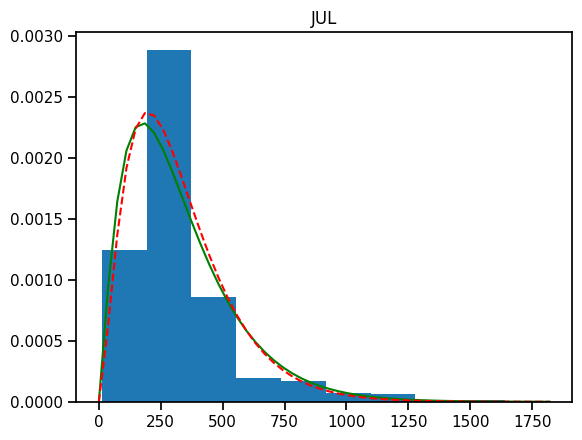

In [90]:
from scipy.stats.distributions import gamma
rain_data_jul.hist(density=True, bins=10, grid=False)
x = np.linspace(0, rain_data_jul.max())
plt.plot(x, gamma.pdf(x, a=alpha_mom, scale=beta_mom), 'g-')
plt.plot(x, gamma.pdf(x, a=alpha_mle, scale=(1/beta_mle)), 'r--')

In [113]:
rain = pd.DataFrame(dict(content=(rain_data_jun['JUN']), group = 'Rain Data'))
trial_data = pd.concat([rain], ignore_index=True)
trial_data.hist('content',by='group')

<AxesSubplot: title={'center': 'Rain Data'}>

## Building Bayesian Model and  Picking our Priors

In [115]:
from pymc3 import Model, Uniform
from pymc3 import StudentT, Normal

with Model() as India_Rainfall_Model:
    μ_0 = Normal('μ_0', 326, sd=221)
    μ_1 = Normal('μ_1', 326, sd=221)

In [116]:
with India_Rainfall_Model:
    σ_0 = Uniform('σ_0', lower=0, upper=20)
    σ_1 = Uniform('σ_1', lower=0, upper=20)

In [117]:
from pymc3 import Exponential
with India_Rainfall_Model:
    ν = Exponential('ν_minus_one', 1/29.) + 1

In [118]:
with India_Rainfall_Model:
    rain_jun = StudentT('rain_jun', nu=ν, mu=μ_1, lam=σ_1**2, observed=rain_data['JUN'])
    rain_jul = StudentT('rain_jul', nu=ν, mu=μ_0, lam=σ_0**2, observed=rain_data['JUL'])

In [119]:
from pymc3 import Deterministic
    
with India_Rainfall_Model:
    diff_of_means = Deterministic('difference of means', μ_1 - μ_0)
    effect_size = Deterministic('effect size', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))

In [120]:
from pymc3 import fit

with India_Rainfall_Model: 
    df_tsd_sample_data = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 20,482


Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


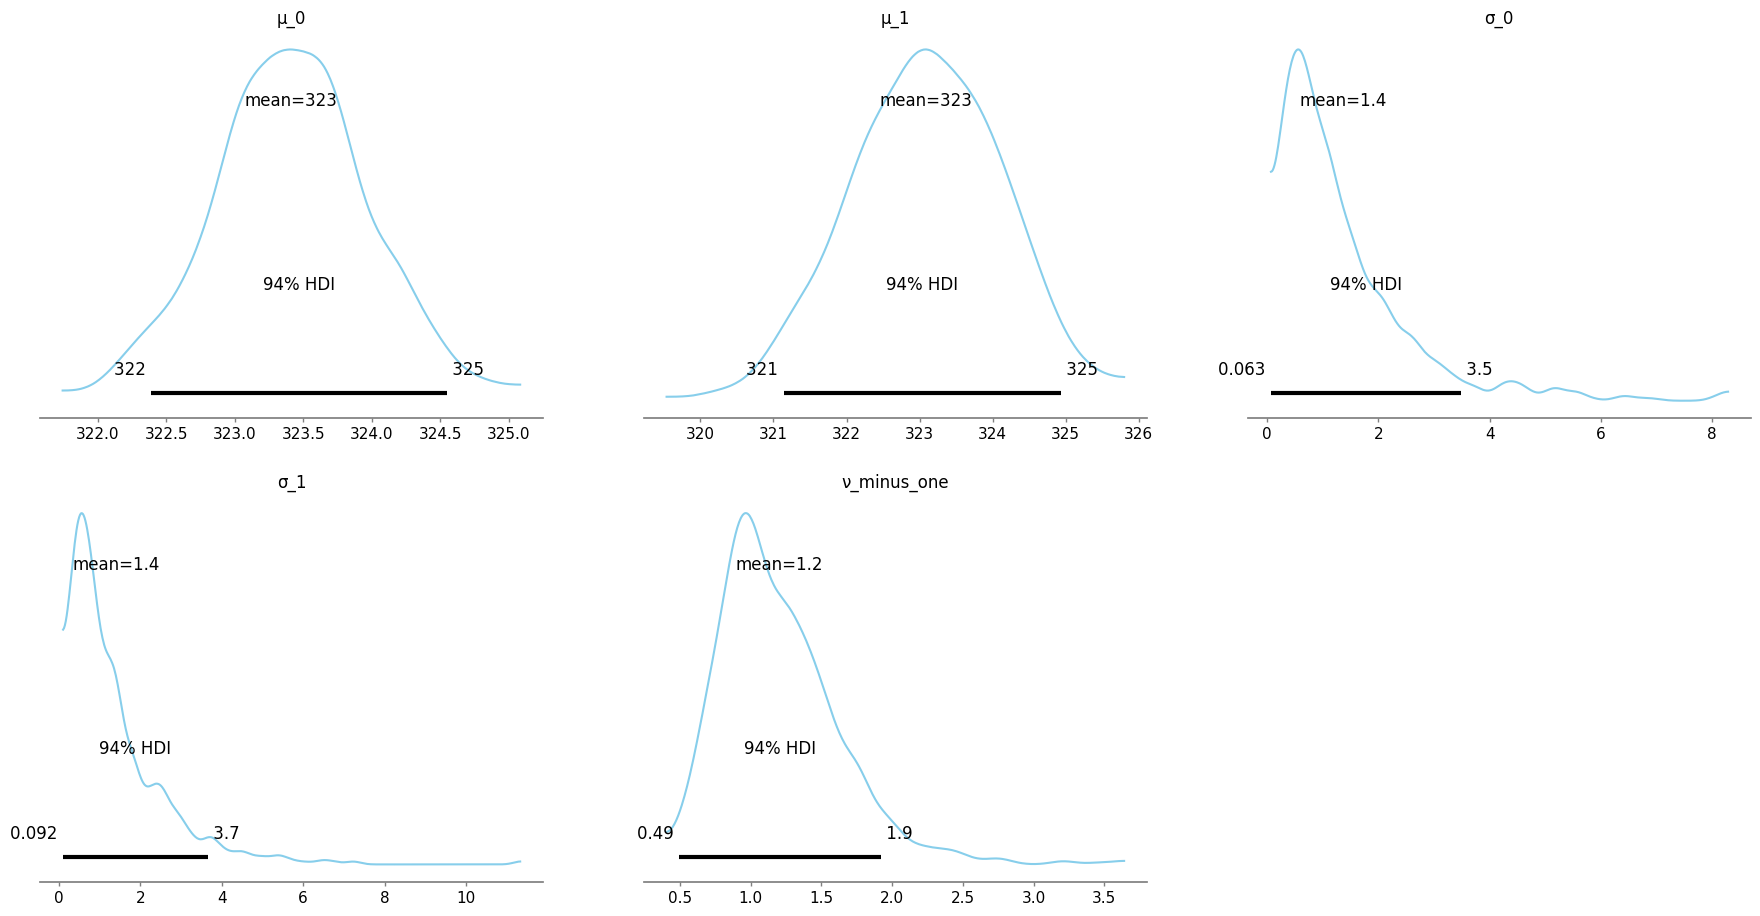

In [121]:
from pymc3 import plot_posterior

plot_posterior(df_tsd_sample_data[100:], 
                var_names=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one'],
                color='#87ceeb');

Got error No model on context stack. trying to find log_likelihood in translation.


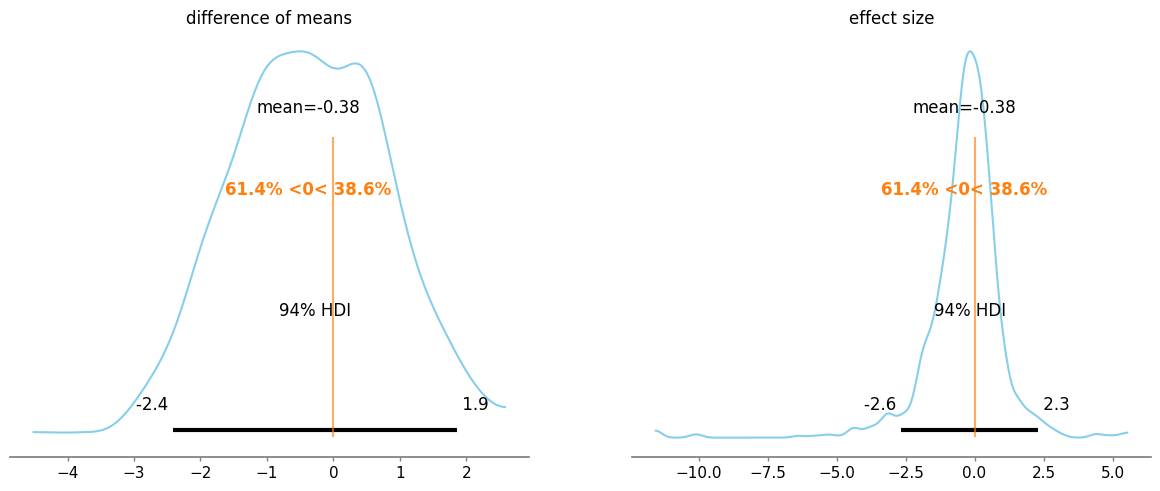

In [76]:
from pymc3 import plot_posterior
plot_posterior(df_tsd_sample_data[100:], 
          var_names=['difference of means', 'effect size'],
          ref_val=0,
          color='#87ceeb');